In [127]:
from datasets import load_dataset

dataset = load_dataset("csv", data_files="data_g1.csv")
dataset

DatasetDict({
    train: Dataset({
        features: ['base_sentence', 'occupation_category'],
        num_rows: 1584
    })
})

In [128]:
df = dataset["train"].to_pandas()
df["occupation_category"].unique()

array(['Technical & Skilled Trades', 'Creative & Professional Services',
       'Management & Administration', 'Service & Support Roles',
       'Healthcare & Social Services'], dtype=object)

In [129]:
df

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
1579,The driver was annoyed with the assistant and ...,Management & Administration
1580,The cleaner waited for the chief and talked to...,Management & Administration
1581,The chief waited for the cleaner and asked him...,Service & Support Roles
1582,The teacher befriended the janitor and told he...,Service & Support Roles


In [130]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

In [131]:
labels = encoder.fit_transform(dataset['train']['occupation_category'])
labels

array([4, 0, 4, ..., 3, 3, 0], dtype=int64)

In [132]:
dataset["train"] = dataset["train"].add_column("label", labels)
dataset['train'] = dataset['train'].remove_columns("occupation_category")
dataset = dataset.rename_column("base_sentence", "text")
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1584
    })
})

In [133]:
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 317
    })
})

In [134]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': Value(dtype='int64', id=None)}

In [135]:
set(dataset["train"]['label'])

{0, 1, 2, 3, 4}

In [136]:
from transformers import AutoTokenizer, DataCollatorWithPadding

checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_texts = tokenizer(dataset["train"]["text"])

In [137]:
def tokenize(sample):
    return tokenizer(sample["text"], truncation=True)

In [138]:
tokenized_dataset = dataset.map(tokenize, batched=True)

Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Map:   0%|          | 0/317 [00:00<?, ? examples/s]

In [139]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [140]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1267
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 317
    })
})

In [141]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="trainer",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    metric_for_best_model="f1",
    num_train_epochs=1,
    learning_rate=0.001,
)

In [142]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [143]:
import evaluate
import numpy as np

metric = evaluate.load("f1")

In [144]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [145]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    compute_metrics=compute_metrics,
    data_collator=data_collator,
)

In [146]:
import torch

In [147]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [148]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [149]:
trainer.train()

  0%|          | 0/159 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 1.5115764141082764, 'eval_f1': 0.14864413977190002, 'eval_runtime': 0.328, 'eval_samples_per_second': 966.467, 'eval_steps_per_second': 121.952, 'epoch': 1.0}
{'train_runtime': 12.1471, 'train_samples_per_second': 104.305, 'train_steps_per_second': 13.09, 'train_loss': 1.6177245326012186, 'epoch': 1.0}


TrainOutput(global_step=159, training_loss=1.6177245326012186, metrics={'train_runtime': 12.1471, 'train_samples_per_second': 104.305, 'train_steps_per_second': 13.09, 'total_flos': 13386649400478.0, 'train_loss': 1.6177245326012186, 'epoch': 1.0})

In [150]:
trainer.evaluate()

  0%|          | 0/40 [00:00<?, ?it/s]

{'eval_loss': 1.5115764141082764,
 'eval_f1': 0.14864413977190002,
 'eval_runtime': 0.3084,
 'eval_samples_per_second': 1028.024,
 'eval_steps_per_second': 129.719,
 'epoch': 1.0}

In [151]:
predictions = trainer.predict(tokenized_dataset["test"])
predictions

  0%|          | 0/40 [00:00<?, ?it/s]

PredictionOutput(predictions=array([[ 0.2585772 , -0.72477764,  0.5420048 ,  0.6427246 ,  0.5777421 ],
       [ 0.2585772 , -0.72477764,  0.5420048 ,  0.6427246 ,  0.5777421 ],
       [ 0.2585772 , -0.72477764,  0.5420048 ,  0.6427246 ,  0.5777421 ],
       ...,
       [ 0.25857717, -0.72477764,  0.5420048 ,  0.6427246 ,  0.5777421 ],
       [ 0.2585772 , -0.72477764,  0.5420048 ,  0.6427246 ,  0.5777421 ],
       [ 0.2585772 , -0.72477764,  0.5420048 ,  0.6427246 ,  0.5777421 ]],
      dtype=float32), label_ids=array([4, 3, 3, 4, 3, 3, 1, 2, 3, 3, 4, 4, 1, 3, 4, 1, 0, 3, 3, 4, 2, 4,
       3, 4, 0, 1, 4, 2, 3, 3, 4, 2, 3, 1, 3, 3, 4, 4, 3, 3, 0, 2, 2, 1,
       3, 0, 2, 2, 4, 3, 4, 0, 2, 3, 1, 3, 4, 0, 3, 4, 2, 4, 3, 4, 2, 2,
       1, 2, 3, 3, 4, 4, 2, 3, 4, 4, 4, 3, 0, 0, 0, 3, 2, 2, 0, 0, 3, 4,
       3, 3, 0, 2, 3, 3, 4, 4, 4, 4, 3, 3, 4, 3, 3, 2, 3, 1, 2, 4, 3, 4,
       3, 2, 3, 3, 2, 2, 4, 2, 2, 4, 4, 3, 4, 2, 0, 4, 3, 2, 4, 0, 2, 4,
       2, 4, 4, 4, 3, 2, 0, 2, 2, 3, 4, 4, 4

In [196]:
logits, labels = predictions.predictions, predictions.label_ids
preds = np.argmax(logits, axis=-1)
preds

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [197]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [198]:
print(classification_report(labels, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        48
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        66
           3       0.31      1.00      0.48        99
           4       0.00      0.00      0.00        84

    accuracy                           0.31       317
   macro avg       0.06      0.20      0.10       317
weighted avg       0.10      0.31      0.15       317



C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Text(0.5, 1.0, 'Confusion Matrix')

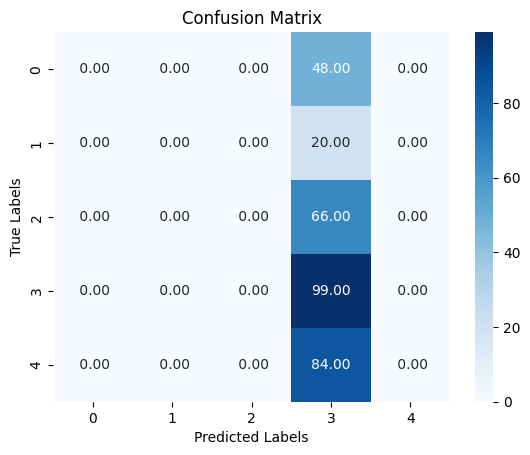

In [199]:
sns.heatmap(confusion_matrix(labels, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

In [200]:
encoder.inverse_transform([0, 1, 2, 3, 4])

array(['Creative & Professional Services', 'Healthcare & Social Services',
       'Management & Administration', 'Service & Support Roles',
       'Technical & Skilled Trades'], dtype='<U32')

In [201]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tf_keras.preprocessing.text import Tokenizer
from tf_keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, LSTM, Flatten
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [202]:
data = pd.read_csv("data_g1.csv")
data

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
1579,The driver was annoyed with the assistant and ...,Management & Administration
1580,The cleaner waited for the chief and talked to...,Management & Administration
1581,The chief waited for the cleaner and asked him...,Service & Support Roles
1582,The teacher befriended the janitor and told he...,Service & Support Roles


<Axes: xlabel='occupation_category'>

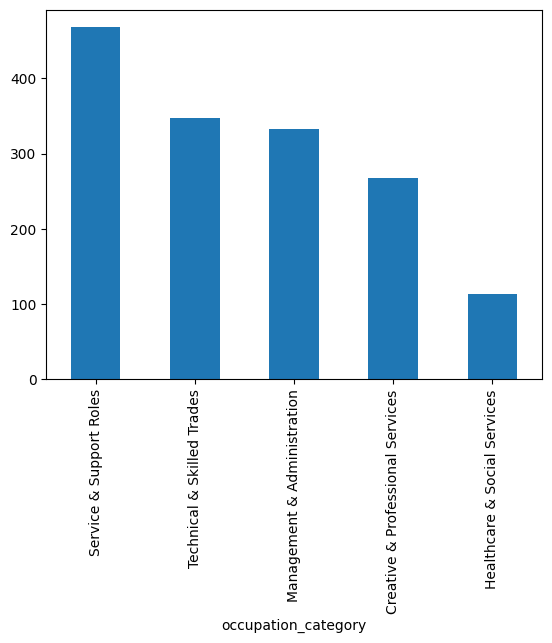

In [203]:
df["occupation_category"].value_counts().plot.bar()

In [204]:
df.isnull().sum()

base_sentence          0
occupation_category    0
dtype: int64

<Axes: ylabel='Frequency'>

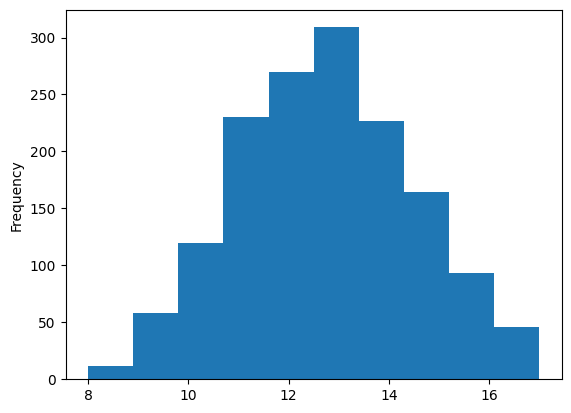

In [205]:
df["base_sentence"].str.split(" ").apply(len).plot.hist()

<Axes: >

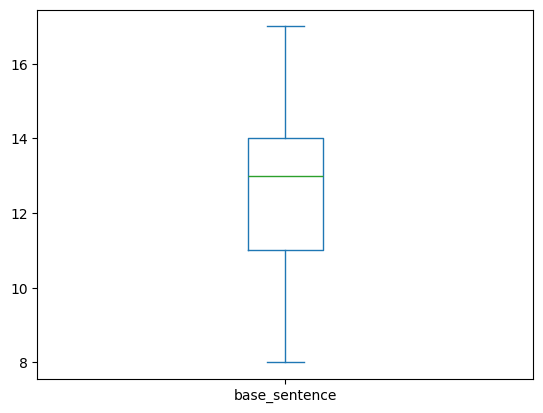

In [206]:
df["base_sentence"].str.split().apply(len).plot.box()

In [207]:
df = df[df["base_sentence"].str.split().apply(len) < 18].copy(deep=True)
df

,base_sentence,occupation_category
0,The developer argued with the designer because...,Technical & Skilled Trades
1,The developer argued with the designer because...,Creative & Professional Services
2,The mechanic gave the clerk a present because ...,Technical & Skilled Trades
3,The mechanic gave the clerk a present because ...,Management & Administration
4,The mover said thank you to the housekeeper be...,Technical & Skilled Trades
...,...,...
1579,The driver was annoyed with the assistant and ...,Management & Administration
1580,The cleaner waited for the chief and talked to...,Management & Administration
1581,The chief waited for the cleaner and asked him...,Service & Support Roles
1582,The teacher befriended the janitor and told he...,Service & Support Roles


<Axes: ylabel='Frequency'>

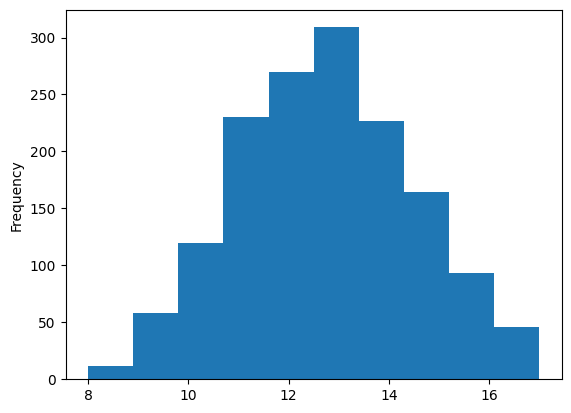

In [208]:
df["base_sentence"].str.split(" ").apply(len).plot.hist()

<Axes: >

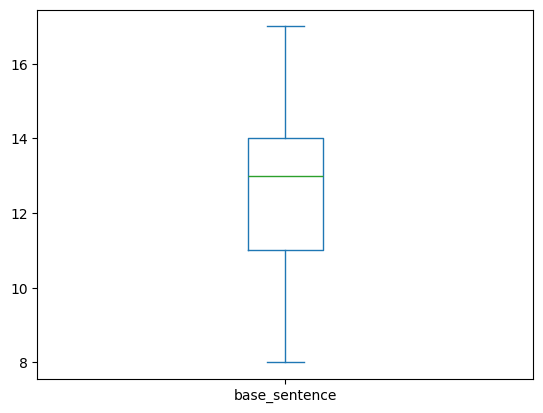

In [209]:
df["base_sentence"].str.split().apply(len).plot.box()

In [210]:
def get_vocabulary(texts):
    vocabulary = []
    for text in texts:
        for word in text.split(" "):
            vocabulary.append(word)
    return list(set(vocabulary))

In [211]:
vocabulary = get_vocabulary(df["base_sentence"].tolist())

In [212]:
vocabulary

['making.',
 'stood',
 'brand.',
 'hand.',
 'tripped',
 'kind',
 'assistance',
 'services',
 'attention',
 'careful',
 'suit',
 'even',
 'about',
 'guilty',
 'received',
 'favors',
 'carelessness',
 'fixed',
 'disease',
 'case.',
 'packed',
 'bully.',
 'ached.',
 'save',
 'well.',
 'wrote',
 'apply.',
 'mood.',
 'increase',
 'name',
 'autograph',
 'needed',
 'provide',
 'beat',
 'in.',
 'new.',
 'fan.',
 'obey',
 'cried',
 'information',
 'concerns',
 'honest.',
 'than',
 'but',
 'protected',
 'mother.',
 'cleaning.',
 'try.',
 'slacking',
 'famous.',
 'down',
 'broom',
 'tester',
 'equipment.',
 'interview.',
 'conclusions.',
 'some',
 "everyone's",
 'neck.',
 'comes,',
 'use',
 'department.',
 'sweater',
 'because',
 'thanks',
 'noticed',
 'holiday.',
 'snooping.',
 'lottery.',
 'employee',
 'comments.',
 'ordered',
 'clearly',
 'email.',
 'although',
 'often',
 'shovel.',
 'hats.',
 'legs.',
 'protestors',
 'rebuked',
 'stability',
 'organized',
 'keeping',
 'threw',
 'should',
 'mo

In [213]:
len(vocabulary)

1942

In [214]:
max_vocabulary_size = 1900

In [215]:
x, y = df["base_sentence"], pd.get_dummies(df["occupation_category"])

In [216]:
y.head()

,Creative & Professional Services,Healthcare & Social Services,Management & Administration,Service & Support Roles,Technical & Skilled Trades
0,False,False,False,False,True
1,True,False,False,False,False
2,False,False,False,False,True
3,False,False,True,False,False
4,False,False,False,False,True


In [217]:
num_classes = y.shape[1]
num_classes

5

In [218]:
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2)

In [219]:
tokenizer = Tokenizer(num_words=max_vocabulary_size)
tokenizer.fit_on_texts(train_x.values)
train_x = tokenizer.texts_to_sequences(train_x)
test_x = tokenizer.texts_to_sequences(test_x)

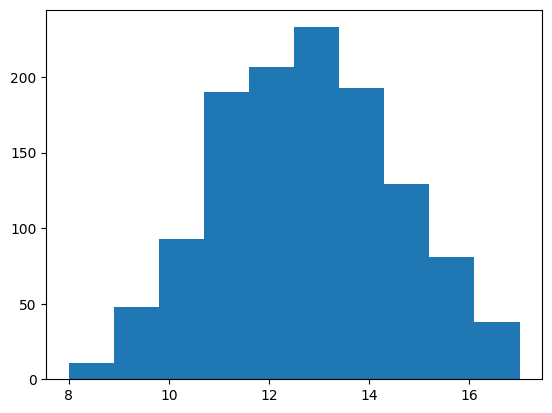

In [220]:
plt.hist([len(tokens) for tokens in train_x]);

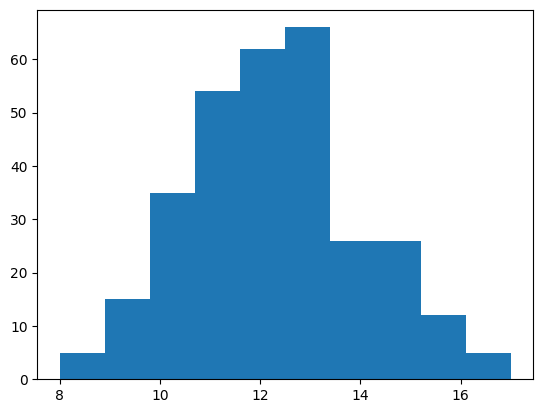

In [221]:
plt.hist([len(tokens) for tokens in test_x]);

In [222]:
maxlen = 16

In [223]:
train_x = sequence.pad_sequences(train_x, maxlen=maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=maxlen)

In [224]:
train_x.shape, test_x.shape

((1223, 16), (306, 16))

In [225]:
model = Sequential([
    Embedding(input_dim=max_vocabulary_size, output_dim=32),
    Conv1D(filters=32, kernel_size=4, padding="same", activation="relu"),
    MaxPooling1D(pool_size=2),
    LSTM(64, dropout=0.1, recurrent_dropout=0.1),
    Dense(num_classes, activation="softmax")
])

In [226]:
model.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["precision", "recall", "f1_score"]
)

In [227]:
history = model.fit(train_x, train_y, validation_split=0.2, batch_size=64, epochs=8)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - f1_score: 0.1387 - loss: 1.5987 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0899 - val_loss: 1.5487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.0903 - loss: 1.5435 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0899 - val_loss: 1.5186 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - f1_score: 0.0903 - loss: 1.5191 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_f1_score: 0.0899 - val_loss: 1.4911 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.0928 - loss: 1.4599 - precision: 0.2459 - recall: 0.0012 - val_f1_score: 0.1155 - val_loss: 1.4155 - val_precision: 0.7273 - val_recall: 0.0327
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - f1_score: 0.2562 - loss: 1.2963 - precision: 0.7772 - recall: 0.0969 - v

<Axes: >

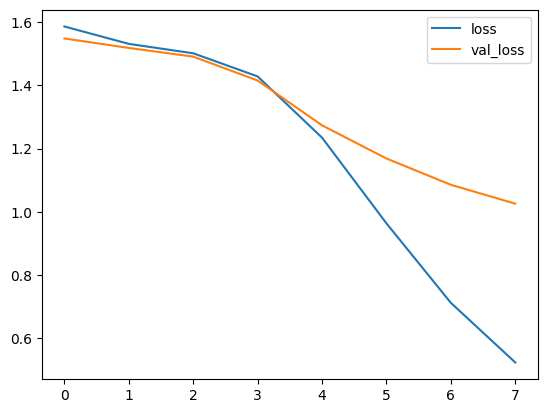

In [228]:
sns.lineplot(history.history["loss"], label="loss")
sns.lineplot(history.history["val_loss"], label="val_loss")

In [229]:
preds = model.predict(test_x)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [230]:
test_y = test_y.values.argmax(axis=1)
preds = preds.argmax(axis=1)

In [231]:
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.68      0.78      0.72        49
           1       0.00      0.00      0.00        15
           2       0.56      0.69      0.62        59
           3       0.77      0.70      0.74        97
           4       0.76      0.79      0.78        86

    accuracy                           0.70       306
   macro avg       0.56      0.59      0.57       306
weighted avg       0.68      0.70      0.69       306



C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

Text(0.5, 1.0, 'Confusion Matrix')

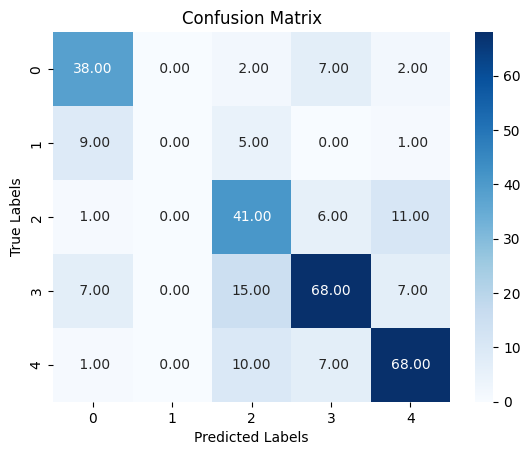

In [232]:
sns.heatmap(confusion_matrix(test_y, preds), annot=True, fmt="5.2f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")